C:\Users\julia\AppData\Local\Temp\ipykernel_14704\1944295534.py:86: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_returns_df['daily_return'].fillna(0, inplace=True)


✅ Visualizations created and saved!
- funding_arbitrage_performance.png
- funding_arbitrage_analysis.png


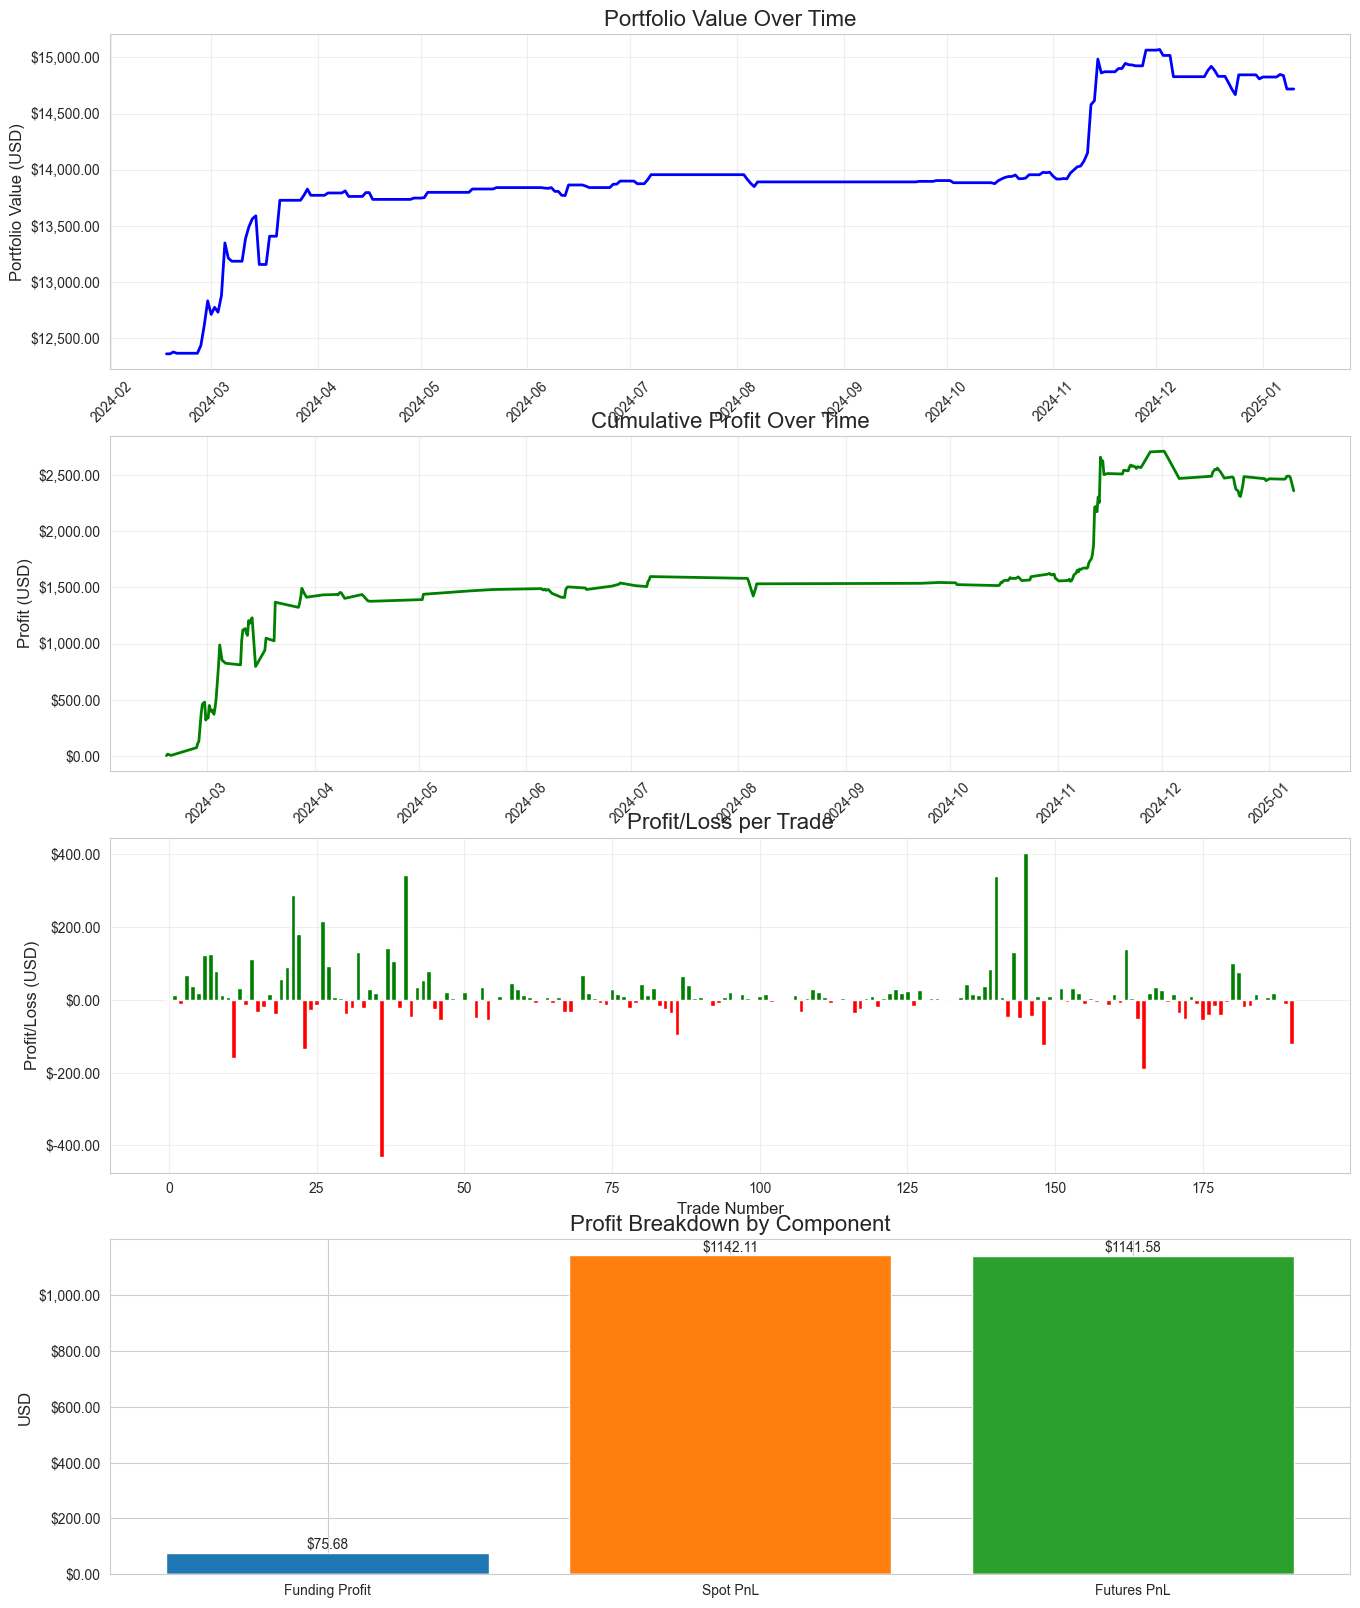

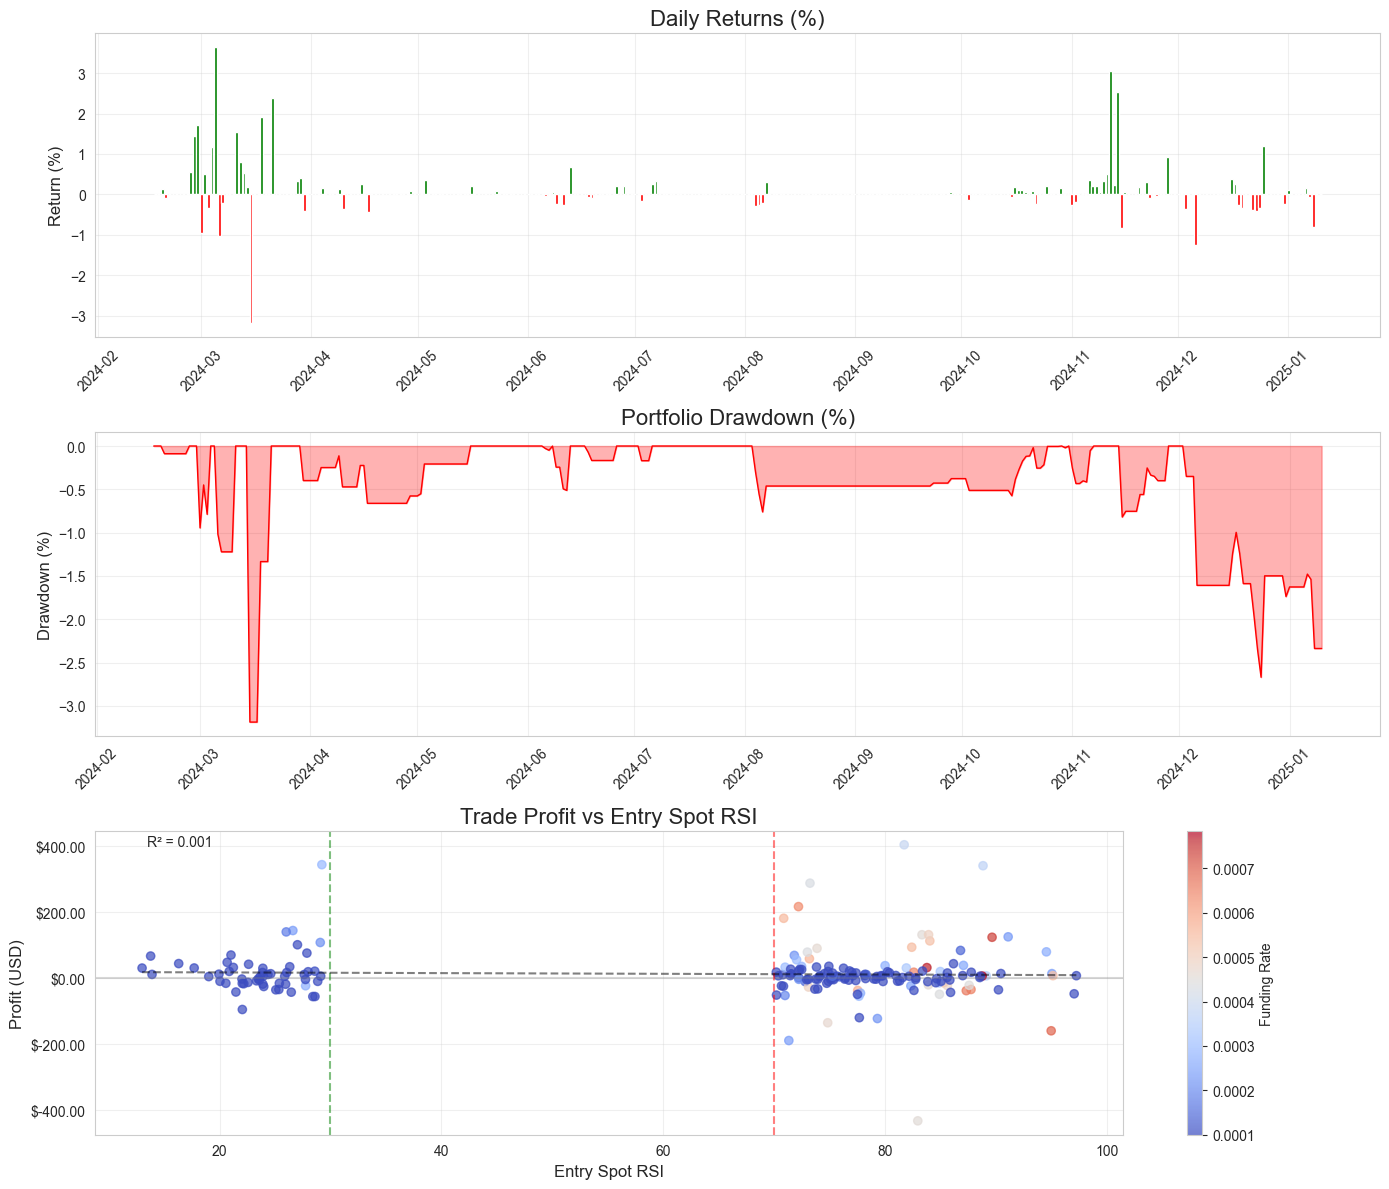

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load our trading results data
# Note: These files should be generated by the original script
results_df = pd.read_csv("dataset/funding_arbitrage_results_2.csv")
daily_returns_df = pd.read_csv("dataset/daily_returns.csv")

# Convert timestamp to datetime
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
daily_returns_df['date'] = pd.to_datetime(daily_returns_df['date'])

# Set the style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 20))

# 1. Portfolio Value Over Time
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(daily_returns_df['date'], daily_returns_df['balance'], 'b-', linewidth=2)
ax1.set_title('Portfolio Value Over Time', fontsize=16)
ax1.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.2f}'))
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Cumulative Profit
ax2 = fig.add_subplot(4, 1, 2)
# Calculate cumulative profit from results
results_df = results_df.sort_values('timestamp')
results_df['cumulative_profit'] = results_df['total_profit'].cumsum()
ax2.plot(results_df['timestamp'], results_df['cumulative_profit'], 'g-', linewidth=2)
ax2.set_title('Cumulative Profit Over Time', fontsize=16)
ax2.set_ylabel('Profit (USD)', fontsize=12)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.2f}'))
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Individual Trade Profits
ax3 = fig.add_subplot(4, 1, 3)
ax3.bar(range(len(results_df)), results_df['total_profit'], color=['g' if p > 0 else 'r' for p in results_df['total_profit']])
ax3.set_title('Profit/Loss per Trade', fontsize=16)
ax3.set_xlabel('Trade Number', fontsize=12)
ax3.set_ylabel('Profit/Loss (USD)', fontsize=12)
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.2f}'))
ax3.grid(True, alpha=0.3)

# 4. Profit Breakdown by Component
ax4 = fig.add_subplot(4, 1, 4)
# Calculate total of each profit component
total_funding_profit = results_df['funding_profit'].sum()
total_spot_pnl = results_df['spot_pnl'].sum()
total_futures_pnl = results_df['futures_pnl'].sum()

components = ['Funding Profit', 'Spot PnL', 'Futures PnL']
values = [total_funding_profit, total_spot_pnl, total_futures_pnl]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose appropriate colors

# Only use positive values for the breakdown visualization
pos_values = [max(0, v) for v in values]
neg_values = [min(0, v) for v in values]

ax4.bar(components, pos_values, color=colors)
ax4.bar(components, neg_values, color=colors)
ax4.set_title('Profit Breakdown by Component', fontsize=16)
ax4.set_ylabel('USD', fontsize=12)
ax4.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.2f}'))

# Add value labels on the bars
for i, v in enumerate(values):
    ax4.text(i, v + (5 if v >= 0 else -20), f'${v:.2f}', 
             ha='center', va='bottom' if v >= 0 else 'top')

# Add drawdown visualization if we have enough data
if len(daily_returns_df) > 1:
    # Create another figure for drawdown analysis
    fig2 = plt.figure(figsize=(14, 12))
    
    # 1. Daily Returns
    ax5 = fig2.add_subplot(3, 1, 1)
    daily_returns_df['daily_return'].fillna(0, inplace=True)
    ax5.bar(daily_returns_df['date'], daily_returns_df['daily_return'] * 100, 
            color=['g' if r > 0 else 'r' for r in daily_returns_df['daily_return']])
    ax5.set_title('Daily Returns (%)', fontsize=16)
    ax5.set_ylabel('Return (%)', fontsize=12)
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45)
    
    # 2. Drawdown Analysis
    ax6 = fig2.add_subplot(3, 1, 2)
    # Calculate drawdown
    daily_returns_df['cumulative_return'] = (1 + daily_returns_df['daily_return']).cumprod()
    daily_returns_df['previous_peak'] = daily_returns_df['cumulative_return'].cummax()
    daily_returns_df['drawdown'] = (daily_returns_df['cumulative_return'] / 
                                    daily_returns_df['previous_peak'] - 1) * 100
    
    ax6.fill_between(daily_returns_df['date'], daily_returns_df['drawdown'], 0, 
                    color='r', alpha=0.3)
    ax6.plot(daily_returns_df['date'], daily_returns_df['drawdown'], 'r-', linewidth=1)
    ax6.set_title('Portfolio Drawdown (%)', fontsize=16)
    ax6.set_ylabel('Drawdown (%)', fontsize=12)
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(axis='x', rotation=45)
    
    # 3. RSI vs Profit Analysis
    ax7 = fig2.add_subplot(3, 1, 3)
    scatter = ax7.scatter(results_df['entry_spot_rsi'], results_df['total_profit'], 
                        c=results_df['funding_rate'], cmap='coolwarm', alpha=0.7)
    ax7.set_title('Trade Profit vs Entry Spot RSI', fontsize=16)
    ax7.set_xlabel('Entry Spot RSI', fontsize=12)
    ax7.set_ylabel('Profit (USD)', fontsize=12)
    ax7.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax7.axvline(x=30, color='green', linestyle='--', alpha=0.5)  # Oversold threshold
    ax7.axvline(x=70, color='red', linestyle='--', alpha=0.5)    # Overbought threshold
    ax7.grid(True, alpha=0.3)
    ax7.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.2f}'))
    cbar = plt.colorbar(scatter)
    cbar.set_label('Funding Rate')

    # Calculate regression line for RSI vs Profit
    if len(results_df) > 2:  # Need at least 3 points for regression
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            results_df['entry_spot_rsi'], results_df['total_profit'])
        x = np.array([min(results_df['entry_spot_rsi']), max(results_df['entry_spot_rsi'])])
        y = slope * x + intercept
        ax7.plot(x, y, 'k--', alpha=0.5)
        r_squared = r_value ** 2
        ax7.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax7.transAxes)

plt.tight_layout()
plt.savefig('graphs/funding_arbitrage_performance.png', dpi=300, bbox_inches='tight')

if 'fig2' in locals():
    fig2.tight_layout()
    plt.figure(fig2.number)
    plt.savefig('graphs/funding_arbitrage_analysis.png', dpi=300, bbox_inches='tight')

print("✅ Visualizations created and saved!")
print("- funding_arbitrage_performance.png")
if 'fig2' in locals():
    print("- funding_arbitrage_analysis.png")

# Display in notebook if you're running in one
plt.show()